In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import game_dataset
from vae_model import NBA_AE
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
import numpy as np
import importlib

In [2]:
class LSTMPredict(nn.Module):
    
    def __init__(self, state_dim, hidden_dim):
        super(LSTMPredict, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(state_dim, hidden_dim)
        self.hidden2delta = nn.Linear(hidden_dim, state_dim)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))
    
    def forward(self, state):
        out, self.hidden = self.lstm(state, self.hidden)
        delta = nn.Tanh()(self.hidden2delta(out))
        next_state = torch.add(delta, state)
        return next_state

In [ ]:
# LOAD TRAINING DATA
importlib.reload(game_dataset)
X = game_dataset.GameDataset('../data/2016.NBA.Raw.SportVU.Game.Logs/',0,5)
# FIND EVENT INDICES
changeidx = [0]
for i in range(len(X)-1):
    a = X[i][1]-X[i+1][0]
    if a[0] != 0.:
        changeidx.append(i + 1)
print('number of loaded events: ', len(changeidx))

In [4]:
# CREATE LSTM INSTANCE
model = LSTMPredict(state_dim = 23, hidden_dim = 64)
loss_function = nn.MSELoss()
optimizer = optim.Adadelta(model.parameters(), weight_decay = 0)

In [ ]:
# TRAIN
for epoch in range(5):
    event_num = 0
    for idx1, idx2 in zip(changeidx[:-1], changeidx[1:]): # loops events
        # Construct data for each event
        inputs = [] 
        targets = []
        for i in range(idx1, idx2):
            inputs.append(X[i][0])
            targets.append(X[i][1])
        inputs = torch.tensor(np.expand_dims(inputs, 1)).float()
        targets = torch.tensor(np.expand_dims(targets, 1)).float()
        
        # Overhead
        model.zero_grad() # clear out gradients
        model.hidden = model.init_hidden() # reinitialize hidden state for each new event
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss and update parameters
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if event_num % 500 == 0:
            print('finished event {}!'.format(event_num))
        event_num += 1
print('done!')

In [ ]:
# SAVE
torch.save(model.state_dict(), "./models/model1")

In [5]:
# LOAD
model.load_state_dict(torch.load("./models/model1"))

In [6]:
# LOAD EVALUATION DATA
importlib.reload(game_dataset)
Y = game_dataset.GameDataset('../data/2016.NBA.Raw.SportVU.Game.Logs/',10,13)
# FIND EVENT INDICES
changeidy = [0]
for i in range(len(Y)-1):
    a = Y[i][1]-Y[i+1][0]
    if a[0] != 0.:
        changeidy.append(i + 1)
print('number of loaded events: ', len(changeidy))

available games:  29
number of loaded events:  674


event 50 length: 223


<IPython.core.display.Javascript object>


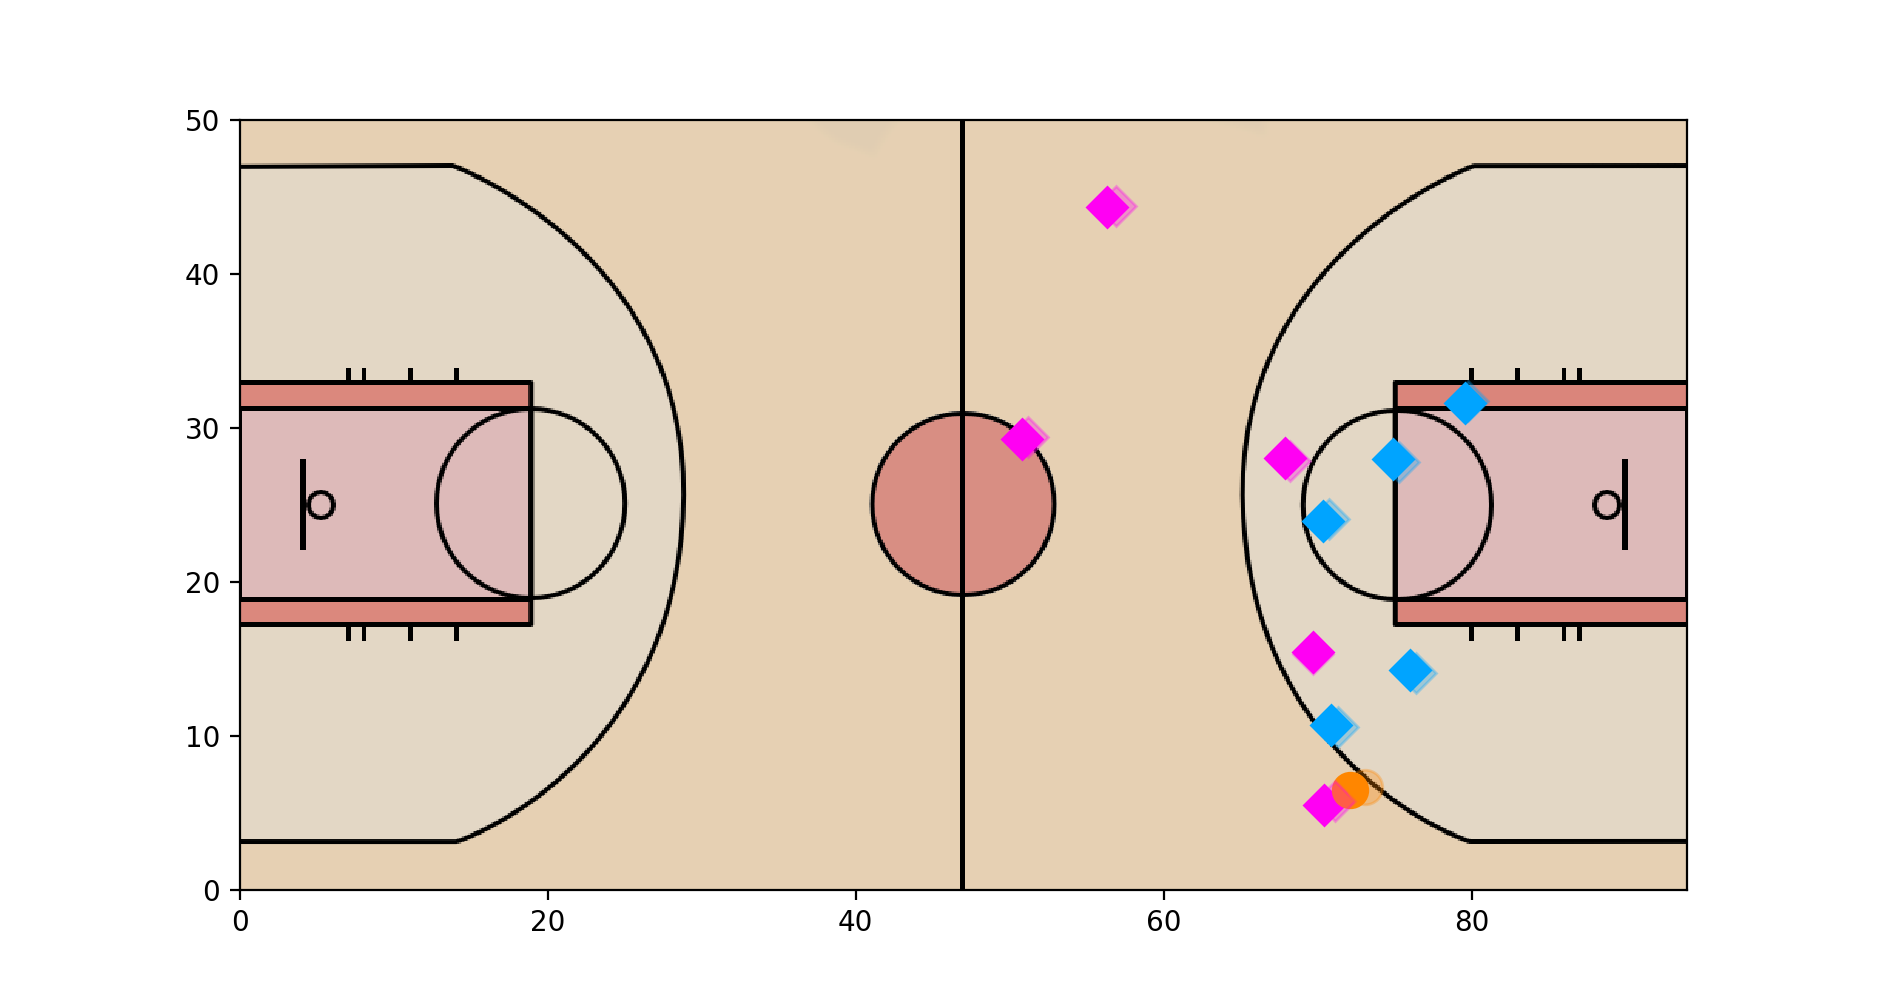

/Users/patricliu/miniconda3/envs/ml_env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [55]:
# how much initial observation of each entity do we get?
horizon = [100,10000,10000] # [home, away, ball] must be at least 1
plotTrajectory(getPredictHorizon(horizon, event = 50), horizon, speed = 1, delay = 1, savename = 'home')

event 10 length: 541


<IPython.core.display.Javascript object>


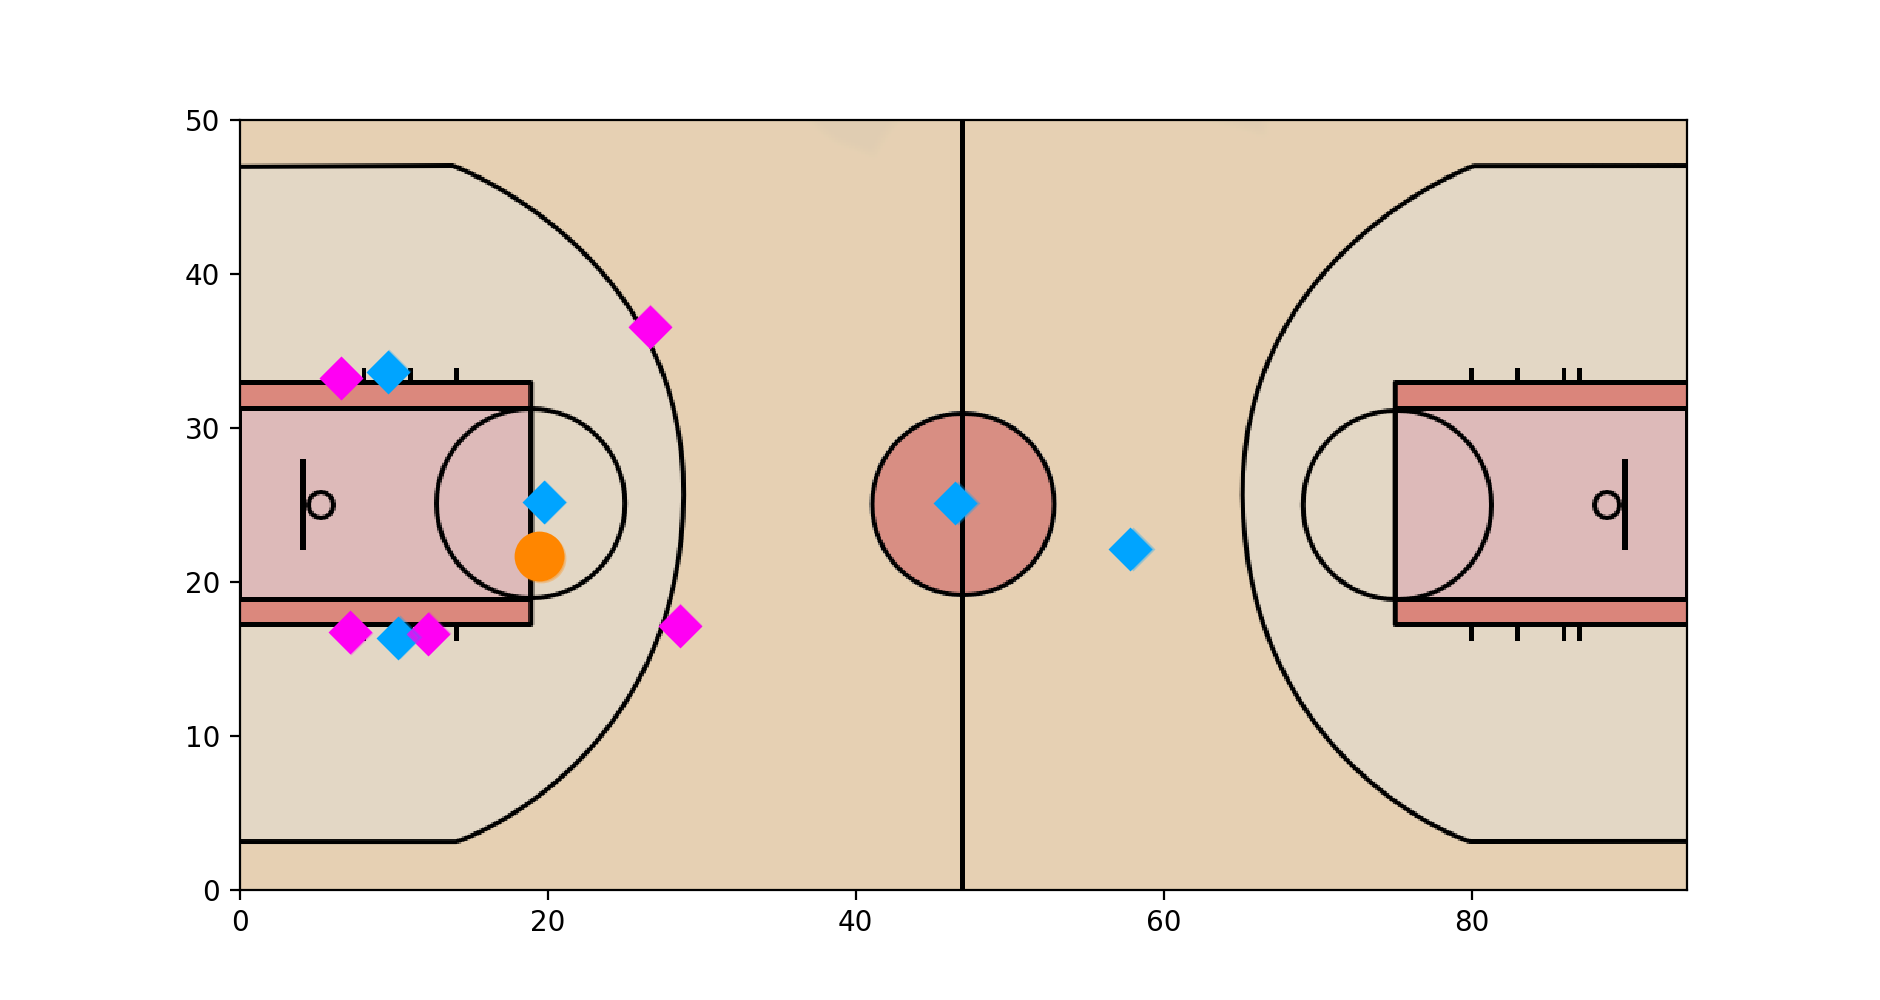

/Users/patricliu/miniconda3/envs/ml_env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [42]:
# how much initial observation of each entity do we get?
horizon = [10000,250,10000] # [home, away, ball] must be at least 1
plotTrajectory(getPredictHorizon(horizon, event = 10), horizon, speed = 1, delay = 1, savename = 'away')

event 11 length: 541


<IPython.core.display.Javascript object>


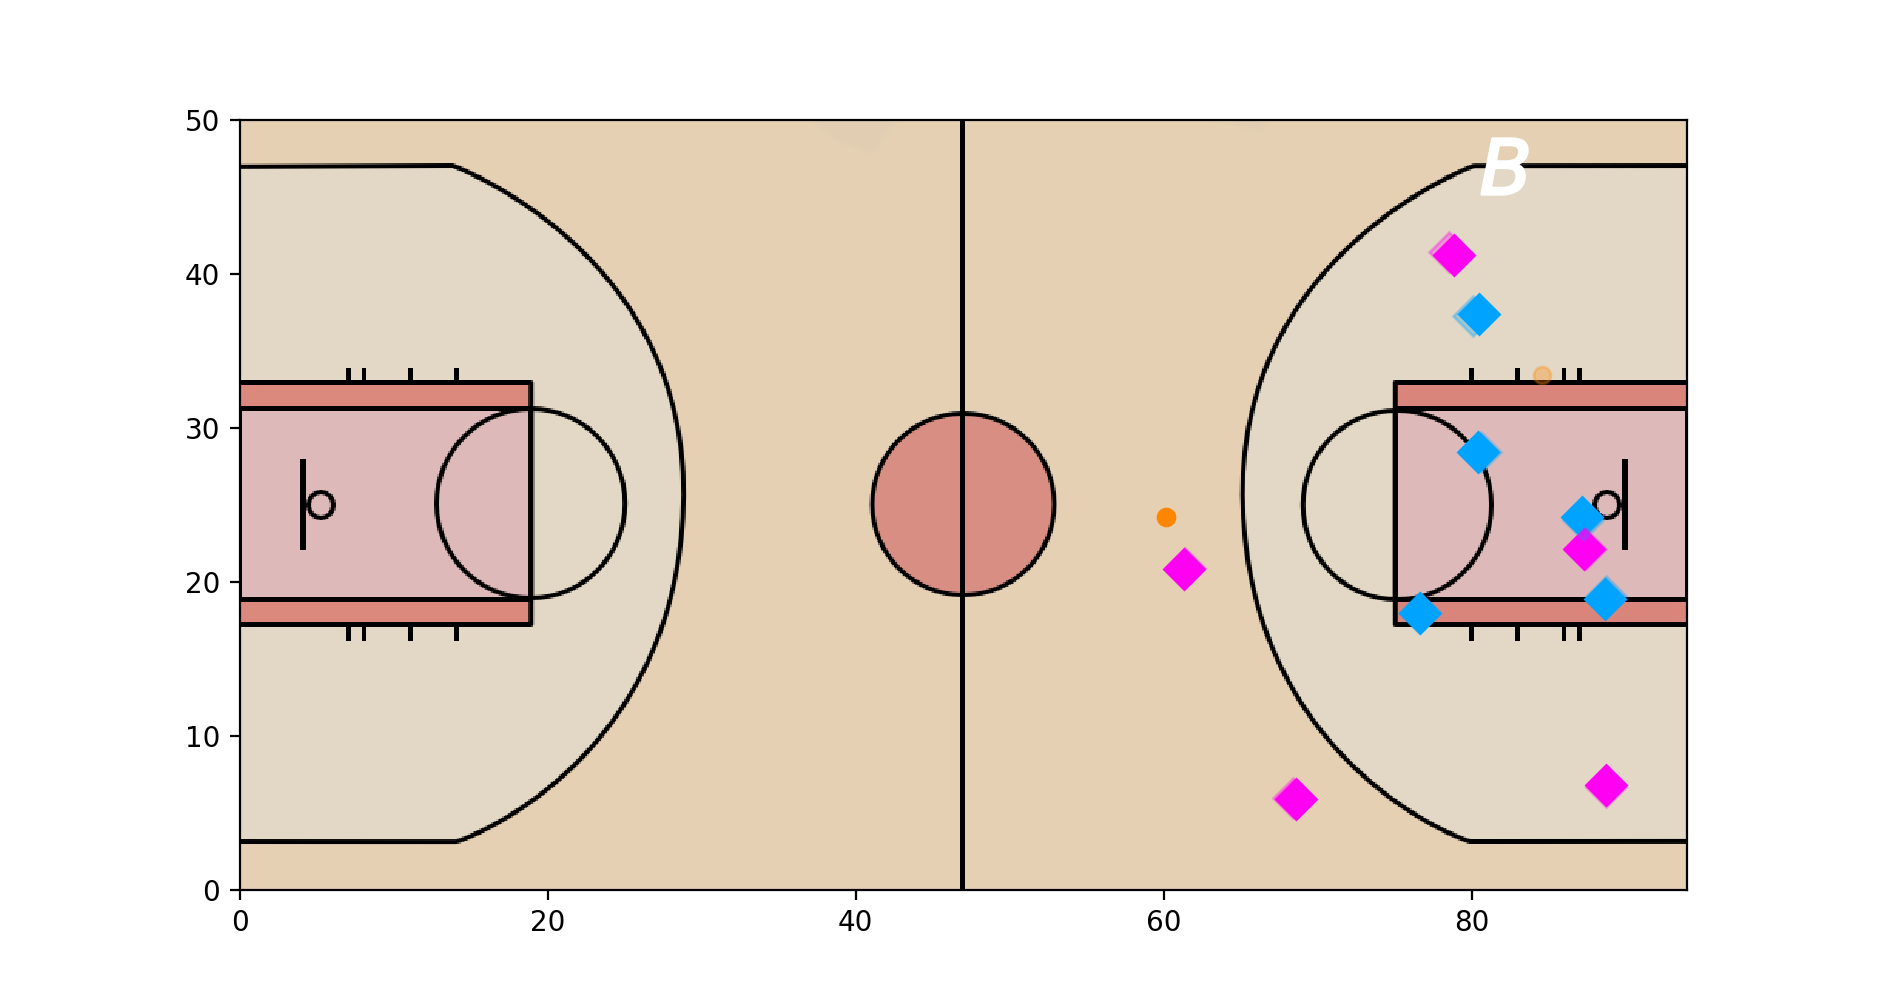

/Users/patricliu/miniconda3/envs/ml_env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [39]:
# how much initial observation of each entity do we get?
horizon = [10000,10000,250] # [home, away, ball] must be at least 1
plotTrajectory(getPredictHorizon(horizon, event = 11), horizon, speed = 1, delay = 1, savename = 'ball')

In [52]:
# PLOTTING FUNCTIONS

%matplotlib notebook

def getTrajectory(event, dataset = 'train'):
    if dataset == 'train':
        idx1, idx2 = changeidx[event], changeidx[event+1]
        steps = idx2 - idx1
        print('event {} length: {}'.format(event, steps))
        trajectory = X[idx1:idx2][0]
        return trajectory
    elif dataset == 'eval':
        idy1, idy2 = changeidy[event], changeidy[event+1]
        steps = idy2 - idy1
        print('event {} length: {}'.format(event, steps))
        trajectory = Y[idy1:idy2][0]
        return trajectory
    
def plotTrajectory(trajectories, horizon, speed=1., delay = 0.2, savename = None):
    %matplotlib notebook
    fig = plt.figure(figsize = (94/10,50/10))
    frames = []
    trans = plt.axes().transAxes
    backdrop = plt.imread('../court.png')
       
    # if real trajectory is not given, do not show
    if len(trajectories[1]) == 0:
        trajectories[1] = -np.ones((len(trajectories[0]),23))
        
    for _, (cord1, cord2) in enumerate(zip(trajectories[0], trajectories[1])):
        coords1 = [[[],[]],[[],[]]]
        coords2 = [[[],[]],[[],[]]]
        for n, t in enumerate([0,10]): # team
            for d in [0,1]: # dimension
                for p in range(0,5):
                    coords1[n][d].append(cord1[2*p + d + t]) 
                    coords2[n][d].append(cord2[2*p + d + t]) 
        height1 = (10 + cord1[22])
        height2 = (10 + cord2[22])
        frame = []
        # prediction
        home1, = plt.plot(coords1[0][0], coords1[0][1], color = '#00a4ff', marker = 'D', linestyle = '', markersize = 10)
        away1, = plt.plot(coords1[1][0], coords1[1][1], color = '#ff00f3', marker = 'D', linestyle = '', markersize = 10)
        ball1, = plt.plot(cord1[20], cord1[21], color = '#ff8600', marker = 'o', linestyle = '', markersize= height1)
        frame.extend([home1, away1, ball1])
        # real (faded)
        home2, = plt.plot(coords2[0][0], coords2[0][1], color = '#00a4ff', marker = 'D', linestyle = '', markersize = 10, alpha = 0.3)
        away2, = plt.plot(coords2[1][0], coords2[1][1], color = '#ff00f3', marker = 'D', linestyle = '', markersize = 10, alpha = 0.3)
        ball2, = plt.plot(cord2[20], cord2[21], color = '#ff8600', marker = 'o', linestyle = '', markersize= height1, alpha = 0.3)
        frame.extend([home2, away2, ball2])
        # horizon marker
        if _ > horizon[0]:
            h, = plt.plot([91], [47], color = 'white', marker = '$H$', linestyle = '', markersize = 20)
            frame.append(h)
        if _ > horizon[1]:
            a, = plt.plot([86.3], [47], color = 'white', marker = '$A$', linestyle = '', markersize = 20)
            frame.append(a)
        if _ > horizon[2]:
            b, = plt.plot([82], [47], color = 'white', marker = '$B$', linestyle = '', markersize = 20)
            frame.append(b)
        # save frame
        frames.append(frame)

    plt.xlim(0,94)
    plt.ylim(0,50)
    plt.axes().set_aspect('equal')
    ani = animation.ArtistAnimation(fig, frames, interval=10 / speed, blit = True, repeat_delay = delay)
    plt.imshow(backdrop,extent = (0,94,0,50))
    if savename != None:
        savename = savename + '.mp4'
        ani.save(savename, fps = 30, bitrate = 1000)
    return ani

def getPredictHorizon(horizon, event, dataset = 'evaluation'):
    if dataset == 'evaluation':
        Z = Y
        changeid = changeidy
    elif dataset == 'test':
        Z = X
        changeid = changeidx
    else:
        print("not a dataset")
        
    id1, id2 = changeid[event], changeid[event+1]
    steps = id2 - id1
    print('event {} length: {}'.format(event, steps))
    
    model.hidden = model.init_hidden() # initialize hidden state
    pred_trajectory = []
    real_trajectory = []
    for n, i in enumerate(range(id1, id2)):
        # get observation
        observation = Z[i][0]
        # replace observation with predictions 
        observation[0:10]  = observation[0:10]  if n < horizon[0] else prediction[0:10]
        observation[10:20] = observation[10:20] if n < horizon[1] else prediction[10:20]
        observation[20:23] = observation[20:23] if n < horizon[2] else prediction[20:23]
        # overhead
        observation = torch.tensor(np.expand_dims([observation], 1)).float()
        # predict
        prediction = model(observation)
        prediction = prediction.detach().numpy().flatten()
        # save prediction and target
        pred_trajectory.append(prediction)
        real_trajectory.append(Z[i][1])
        
    return pred_trajectory, real_trajectory